# Diabetes Prediction - Hyperparameter Tuning

This notebook performs hyperparameter optimization for the top-performing models.

In [1]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import config
import utils

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import joblib

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette(config.COLOR_PALETTE)

import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Data and Previous Results

In [2]:
# Load preprocessed data
X_train = np.load(f'{config.DATA_DIR}/X_train_scaled.npy')
X_test = np.load(f'{config.DATA_DIR}/X_test_scaled.npy')
y_train = np.load(f'{config.DATA_DIR}/y_train.npy')
y_test = np.load(f'{config.DATA_DIR}/y_test.npy')

print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

# Load previous results
results_df = pd.read_csv(f'{config.RESULTS_DIR}/model_performance.csv')
print("\nTop 3 models from previous training:")
print(results_df[['model', 'test_accuracy', 'roc_auc']].head(3))

Training set: (614, 8)
Test set: (154, 8)

Top 3 models from previous training:
                 model  test_accuracy   roc_auc
0        Random Forest       0.753247  0.812593
1                  KNN       0.753247  0.788611
2  Logistic Regression       0.707792  0.812963


In [3]:
# Define models to tune (only best performing models)
# We'll tune Random Forest and KNN based on initial results
models_to_tune = {
    'Random Forest': RandomForestClassifier(random_state=config.RANDOM_STATE),
    'KNN': KNeighborsClassifier()
}

# Define parameter grids for tuning
param_grids = {
    'Random Forest': config.PARAM_GRIDS['random_forest'],
    'KNN': config.PARAM_GRIDS['knn']
}

print(f"Models to tune: {list(models_to_tune.keys())}")


Models to tune: ['Random Forest', 'KNN']


## 2. Select Models for Tuning

## 3. Perform Grid Search

In [4]:
# Perform GridSearchCV for each model
best_models = {}
grid_search_results = {}

print("Starting GridSearchCV...\n")
print("="*80)

for model_name, model in models_to_tune.items():
    print(f"\nTuning {model_name}...")
    print(f"Parameter grid: {len(list(param_grids[model_name].values())[0]) if param_grids[model_name] else 0} combinations")
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[model_name],
        cv=config.CV_FOLDS,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    
    grid_search.fit(X_train, y_train)
    
    # Store results
    best_models[model_name] = grid_search.best_estimator_
    grid_search_results[model_name] = {
        'best_params': grid_search.best_params_,
        'best_cv_score': grid_search.best_score_,
        'grid_search_object': grid_search
    }
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV score: {grid_search.best_score_:.4f}")

print("\n" + "="*80)
print("Grid Search completed!")

Starting GridSearchCV...


Tuning Random Forest...
Parameter grid: 3 combinations
Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'max_depth': 10, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 50}
Best CV score: 0.7801

Tuning KNN...
Parameter grid: 6 combinations
Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best parameters: {'metric': 'euclidean', 'n_neighbors': 15, 'weights': 'distance'}
Best CV score: 0.7688

Grid Search completed!


## 4. Evaluate Tuned Models

In [5]:
# Evaluate tuned models
tuned_results = {}

print("\nEvaluating tuned models...\n")
print("="*80)

for model_name, model in best_models.items():
    # Evaluate
    metrics = utils.evaluate_model(model, X_train, X_test, y_train, y_test)
    tuned_results[model_name] = metrics
    
    # Print results
    utils.print_classification_metrics(f"{model_name} (Tuned)", metrics)

print("="*80)


Evaluating tuned models...


Random Forest (Tuned) Performance Metrics
Train Accuracy:     0.9055
Test Accuracy:      0.7597
Precision:          0.6889
Recall:             0.5741
F1-Score:           0.6263
ROC-AUC:            0.8137
CV Mean (±std):     0.7801 (±0.0186)


KNN (Tuned) Performance Metrics
Train Accuracy:     1.0000
Test Accuracy:      0.7338
Precision:          0.6444
Recall:             0.5370
F1-Score:           0.5859
ROC-AUC:            0.8069
CV Mean (±std):     0.7688 (±0.0321)



## 5. Compare Before and After Tuning

In [6]:
# Create comparison DataFrame
comparison_data = []

for model_name in models_to_tune.keys():
    # Before tuning
    before = results_df[results_df['model'] == model_name].iloc[0]
    
    comparison_data.append({
        'model': model_name,
        'status': 'Before Tuning',
        'test_accuracy': before['test_accuracy'],
        'precision': before['precision'],
        'recall': before['recall'],
        'f1_score': before['f1_score'],
        'roc_auc': before['roc_auc']
    })
    
    # After tuning
    after = tuned_results[model_name]
    comparison_data.append({
        'model': model_name,
        'status': 'After Tuning',
        'test_accuracy': after['test_accuracy'],
        'precision': after['precision'],
        'recall': after['recall'],
        'f1_score': after['f1_score'],
        'roc_auc': after['roc_auc']
    })

comparison_df = pd.DataFrame(comparison_data)

print("\nPerformance Comparison:")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)


Performance Comparison:
        model        status  test_accuracy  precision   recall  f1_score  roc_auc
Random Forest Before Tuning       0.753247   0.673913 0.574074  0.620000 0.812593
Random Forest  After Tuning       0.759740   0.688889 0.574074  0.626263 0.813704
          KNN Before Tuning       0.753247   0.660000 0.611111  0.634615 0.788611
          KNN  After Tuning       0.733766   0.644444 0.537037  0.585859 0.806852


## 6. Visualize Improvement

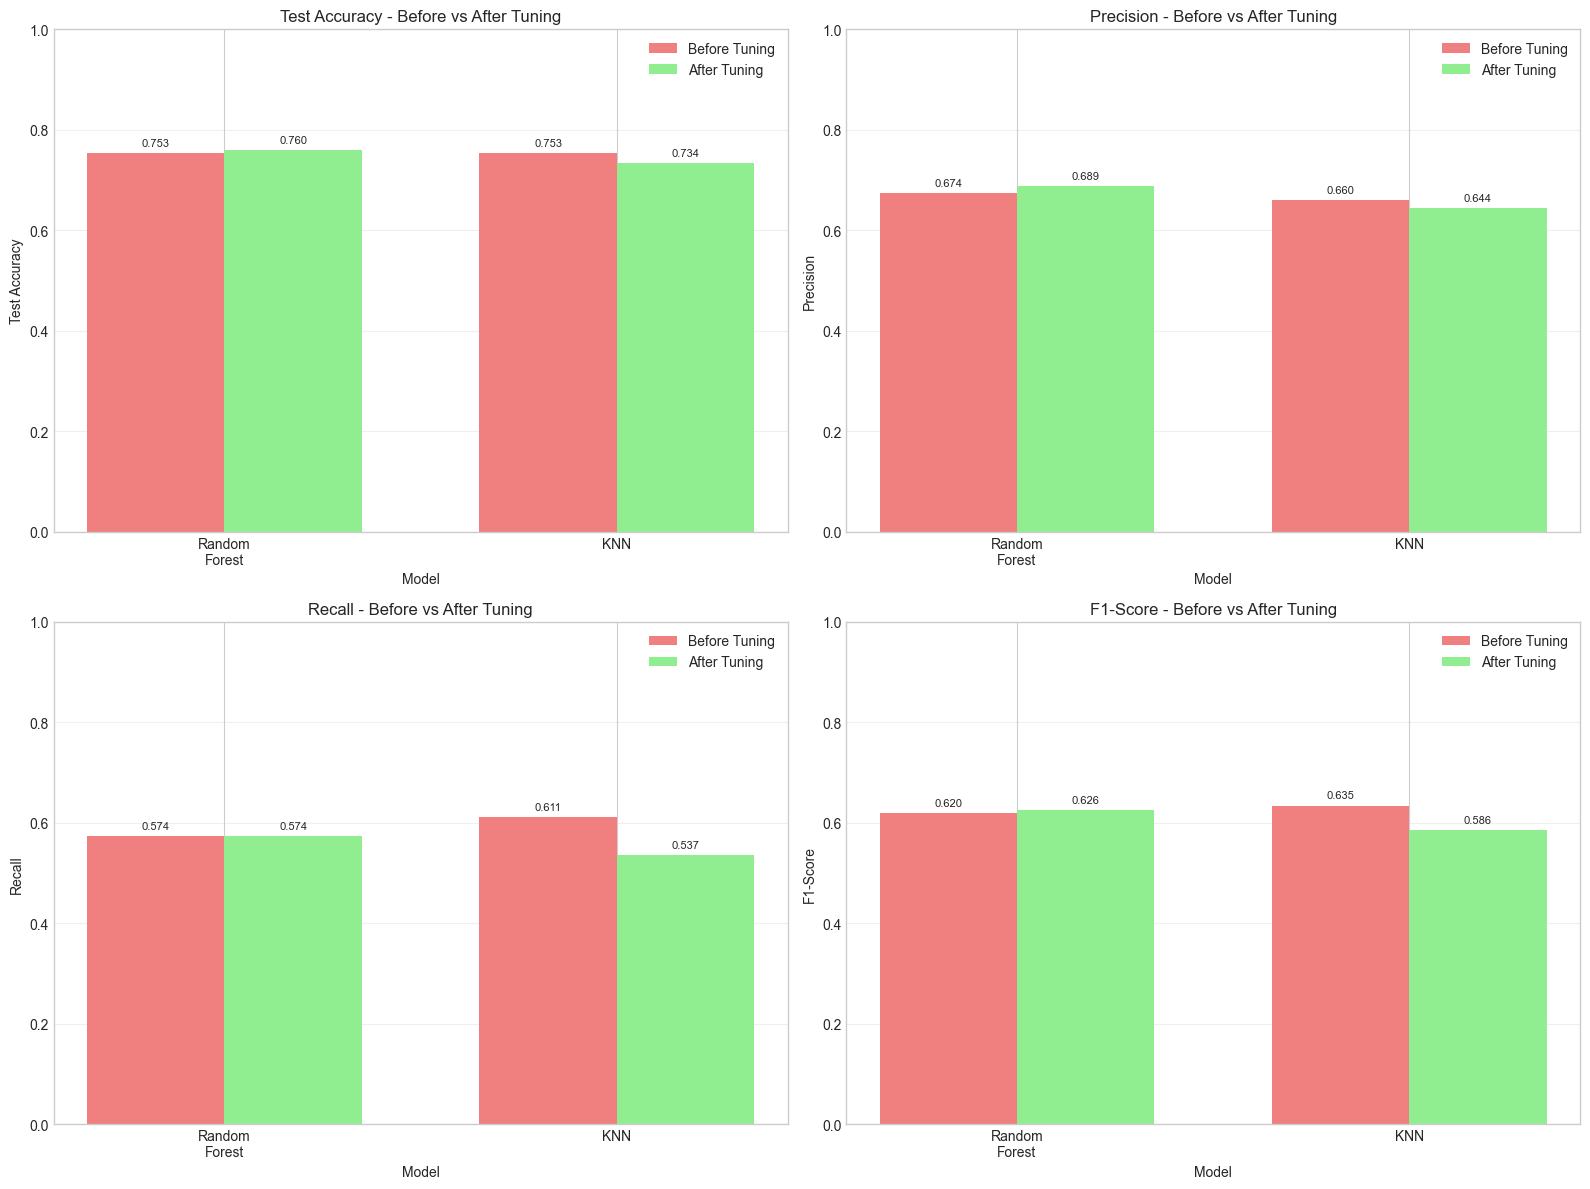

In [7]:
# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

metrics = ['test_accuracy', 'precision', 'recall', 'f1_score']
titles = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']

for idx, (metric, title) in enumerate(zip(metrics, titles)):
    ax = axes[idx]
    
    # Prepare data for grouped bar plot
    models = comparison_df['model'].unique()
    x = np.arange(len(models))
    width = 0.35
    
    before_values = []
    after_values = []
    
    for model in models:
        before = comparison_df[(comparison_df['model'] == model) & 
                               (comparison_df['status'] == 'Before Tuning')][metric].values[0]
        after = comparison_df[(comparison_df['model'] == model) & 
                              (comparison_df['status'] == 'After Tuning')][metric].values[0]
        before_values.append(before)
        after_values.append(after)
    
    # Create bars
    bars1 = ax.bar(x - width/2, before_values, width, label='Before Tuning', color='lightcoral')
    bars2 = ax.bar(x + width/2, after_values, width, label='After Tuning', color='lightgreen')
    
    ax.set_xlabel('Model')
    ax.set_ylabel(title)
    ax.set_title(f'{title} - Before vs After Tuning')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace(' ', '\n') for m in models])
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])
    
    # Add value labels
    for bar in bars1 + bars2:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig(f'{config.FIGURES_DIR}/14_tuning_comparison.png', dpi=config.FIGURE_DPI, bbox_inches='tight')
plt.show()

## 7. Select and Save Final Best Model

In [8]:
# Find best tuned model using standard ML approach
# Primary: Test F1-score (unseen data performance)
# Validation: CV score consistency check

print("\n" + "="*100)
print("TUNED MODEL EVALUATION")
print("="*100)

best_f1 = 0
final_best_model_name = None
final_best_model = None

for model_name, metrics in tuned_results.items():
    test_f1 = metrics['f1_score']
    cv_score = metrics['cv_mean']
    consistency = abs(test_f1 - cv_score)
    
    print(f"\n{model_name}:")
    print(f"  Test F1-Score: {test_f1:.4f}")
    print(f"  CV Score (accuracy): {cv_score:.4f}")
    print(f"  Test Accuracy: {metrics['test_accuracy']:.4f}")
    print(f"  Precision: {metrics['precision']:.4f}")
    print(f"  Recall: {metrics['recall']:.4f}")
    print(f"  CV-Test Consistency: {consistency:.4f}")
    
    if consistency > 0.10:
        print(f"  ⚠️  WARNING: CV and test scores differ significantly")
    
    if test_f1 > best_f1:
        best_f1 = test_f1
        final_best_model_name = model_name
        final_best_model = best_models[model_name]

print("\n" + "="*100)
print("FINAL BEST MODEL (After Hyperparameter Tuning)")
print("="*100)
print(f"\n✓ Selected Model: {final_best_model_name}")

print("\n📊 SELECTION CRITERIA:")
print("  • Primary Metric: Test F1-Score (performance on unseen data)")
print("  • Validation: Cross-validation score consistency")
print("  • Why F1: Balances precision and recall for medical diagnosis")
print("  • GridSearchCV: Used F1 scoring for hyperparameter optimization")

print(f"\nBest Hyperparameters:")
for param, value in grid_search_results[final_best_model_name]['best_params'].items():
    print(f"  {param}: {value}")

final_metrics = tuned_results[final_best_model_name]
print(f"\nPerformance Metrics:")
print(f"  Test F1-Score:  {final_metrics['f1_score']:.4f}")
print(f"  Test Accuracy:  {final_metrics['test_accuracy']:.4f}")
print(f"  Precision:      {final_metrics['precision']:.4f}")
print(f"  Recall:         {final_metrics['recall']:.4f}")
print(f"  ROC-AUC:        {final_metrics['roc_auc']:.4f}")
print(f"  CV Mean (±std): {final_metrics['cv_mean']:.4f} (±{final_metrics['cv_std']:.4f})")

overfitting_gap = final_metrics['train_accuracy'] - final_metrics['test_accuracy']
if overfitting_gap > 0.15:
    print(f"\n  ⚠️  Overfitting detected: {overfitting_gap:.1%} train-test gap")
else:
    print(f"\n  ✓ Good generalization: {overfitting_gap:.1%} train-test gap")

print("="*100)

# Save final best model
utils.save_model(final_best_model, 'best_model_tuned.pkl')

# Save best parameters
params_df = pd.DataFrame([grid_search_results[final_best_model_name]['best_params']])
params_df.insert(0, 'model', final_best_model_name)
params_df.to_csv(f'{config.RESULTS_DIR}/best_model_params.csv', index=False)

print(f"\n✓ Final best model saved to: {config.MODELS_DIR}/best_model_tuned.pkl")
print(f"✓ Best parameters saved to: {config.RESULTS_DIR}/best_model_params.csv")


FINAL BEST MODEL (After Hyperparameter Tuning)

Model: Random Forest

Best Parameters:
  max_depth: 10
  min_samples_leaf: 4
  min_samples_split: 2
  n_estimators: 50

Performance Metrics:
  Test Accuracy:  0.7597
  Precision:      0.6889
  Recall:         0.5741
  F1-Score:       0.6263
  ROC-AUC:        0.8137
  CV Mean (±std): 0.7801 (±0.0186)
Model saved to: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/models/best_model_tuned.pkl

✓ Final best model saved to: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/models/best_model_tuned.pkl
✓ Best parameters saved to: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/results/best_model_params.csv


## 8. Confusion Matrix for Final Model

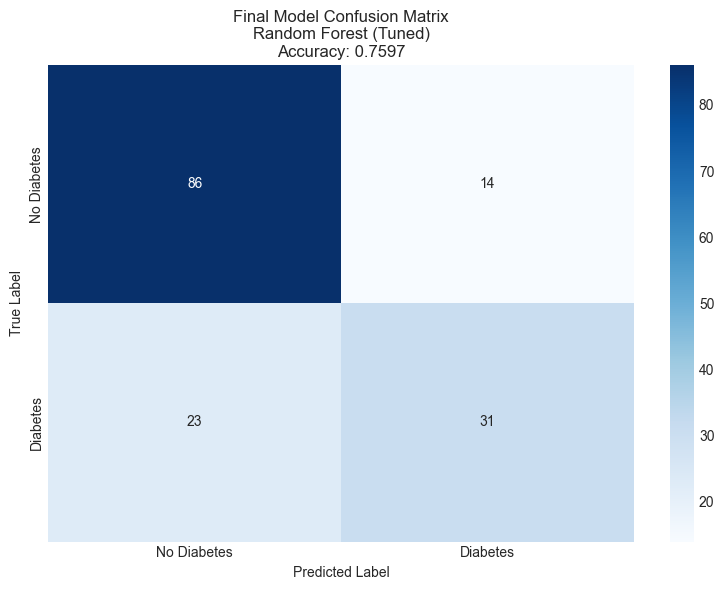

In [9]:
# Plot final model confusion matrix
cm = final_metrics['confusion_matrix']
utils.plot_confusion_matrix(
    cm, 
    title=f'Final Model Confusion Matrix\n{final_best_model_name} (Tuned)\nAccuracy: {final_metrics["test_accuracy"]:.4f}',
    save_path=f'{config.FIGURES_DIR}/15_final_confusion_matrix.png'
)

## 9. ROC Curve for Final Model

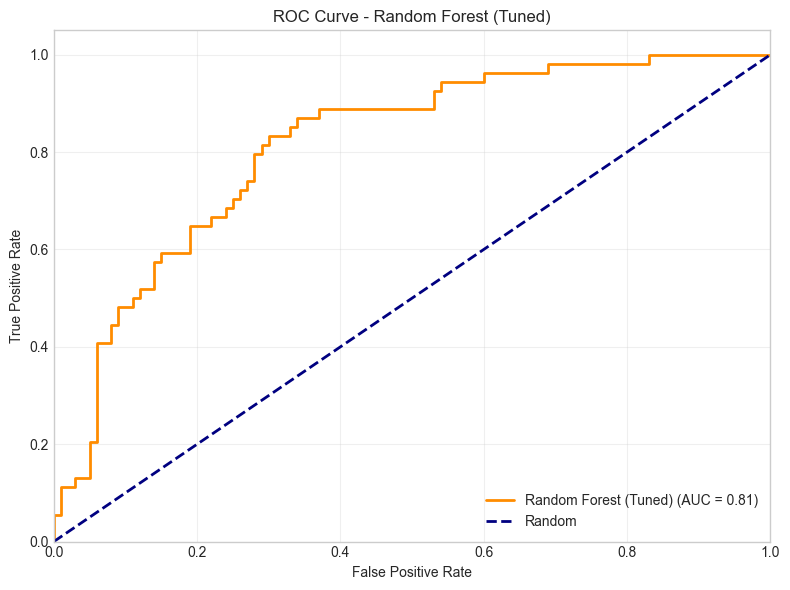

In [10]:
# Plot ROC curve for final model
if hasattr(final_best_model, 'predict_proba'):
    y_proba = final_best_model.predict_proba(X_test)[:, 1]
else:
    y_proba = final_best_model.decision_function(X_test)

utils.plot_roc_curve(
    y_test, 
    y_proba, 
    model_name=f'{final_best_model_name} (Tuned)',
    save_path=f'{config.FIGURES_DIR}/16_final_roc_curve.png'
)

## 10. Project Summary

In [11]:
print("\n" + "="*80)
print("DIABETES PREDICTION PROJECT - FINAL SUMMARY")
print("="*80)

print("\n📊 DATASET:")
print(f"  • Total samples: {len(X_train) + len(X_test)}")
print(f"  • Training samples: {len(X_train)}")
print(f"  • Test samples: {len(X_test)}")
print(f"  • Features: {len(config.FEATURE_NAMES)}")

print("\n🤖 MODELS EVALUATED:")
print(f"  • Initial models trained: {len(results_df)}")
print(f"  • Models hyperparameter tuned: {len(models_to_tune)}")

print("\n🏆 FINAL BEST MODEL:")
print(f"  • Algorithm: {final_best_model_name}")
print(f"  • Test Accuracy: {final_metrics['test_accuracy']:.4f}")
print(f"  • Precision: {final_metrics['precision']:.4f}")
print(f"  • Recall: {final_metrics['recall']:.4f}")
print(f"  • F1-Score: {final_metrics['f1_score']:.4f}")
print(f"  • ROC-AUC: {final_metrics['roc_auc']:.4f}")

print("\n📈 IMPROVEMENTS FROM TUNING:")
original_acc = results_df[results_df['model'] == final_best_model_name]['test_accuracy'].values[0]
improvement = (final_metrics['test_accuracy'] - original_acc) * 100
print(f"  • Accuracy improvement: {improvement:+.2f}%")

print("\n💾 SAVED ARTIFACTS:")
print(f"  • Best model: {config.MODELS_DIR}/best_model_tuned.pkl")
print(f"  • Scaler: {config.MODELS_DIR}/scaler.pkl")
print(f"  • Performance metrics: {config.RESULTS_DIR}/model_performance.csv")
print(f"  • Best parameters: {config.RESULTS_DIR}/best_model_params.csv")
print(f"  • Visualizations: {config.FIGURES_DIR}/")

print("\n✅ PROJECT COMPLETE!")
print("="*80 + "\n")


DIABETES PREDICTION PROJECT - FINAL SUMMARY

📊 DATASET:
  • Total samples: 768
  • Training samples: 614
  • Test samples: 154
  • Features: 8

🤖 MODELS EVALUATED:
  • Initial models trained: 5
  • Models hyperparameter tuned: 2

🏆 FINAL BEST MODEL:
  • Algorithm: Random Forest
  • Test Accuracy: 0.7597
  • Precision: 0.6889
  • Recall: 0.5741
  • F1-Score: 0.6263
  • ROC-AUC: 0.8137

📈 IMPROVEMENTS FROM TUNING:
  • Accuracy improvement: +0.65%

💾 SAVED ARTIFACTS:
  • Best model: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/models/best_model_tuned.pkl
  • Scaler: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/models/scaler.pkl
  • Performance metrics: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/results/model_performance.csv
  • Best parameters: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/results/best_model_params.csv
  • Visualizations: /Users/hasantezcan/Diabet Prediction Project/Diabetis-Prediction/resul